In [86]:
import pandas as pd
import numpy as np
import math
from sklearn import cross_validation, datasets, linear_model, metrics, feature_extraction, model_selection
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
df = pd.read_csv("train_dataset.csv")

In [3]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [4]:
df["TailNum"] = df["TailNum"].fillna("UNKNOWN")

In [6]:
df['TaxiOut'] = df['TaxiOut'].fillna(df['TaxiOut'].mean())

df['AirTime'] = df['AirTime'].fillna(df['AirTime'].mean())

df['DepTime'] = df['DepTime'].fillna(df['DepTime'].mean())

df['ArrTime'] = df['ArrTime'].fillna(df['ArrTime'].mean())

df['TaxiIn'] = df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [9]:
seasons = ("-", "W", "W", "P", "P", "P", "S", "S", "S", "A", "A", "A", "W")
df["Season"] = df["Month"].map(lambda m: seasons[m])

In [200]:
def reclassMean(frame, targetSrc, clsName, meanName):
    def getMean(c, meanInfo): 
        if c not in meanInfo:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetSrc.groupby(clsName)["target"].mean()
    frame[meanName] = frame[clsName].map(lambda c: getMean(c, meanInfo))

In [246]:
reclassMean(df, df, "UniqueCarrier", "CarrierChance")
reclassMean(df, df, "Dest", "DestChance")
reclassMean(df, df, "Origin", "OriginChance")
reclassMean(df, df, "TailNum", "Speed")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target,Season,CarrierChance,DestChance,OriginChance,Speed
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1,W,0.330748,0.264919,0.249355,0.315904
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1,W,0.238788,0.225465,0.235487,0.199134
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0,W,0.302457,0.306310,0.235227,0.324830
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1,W,0.302457,0.332585,0.263668,0.297125
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1,W,0.231669,0.321040,0.297125,0.244681


In [313]:
df["IsHoliday"] = df["DayOfWeek"].map(lambda d: 1 if d == 6 or d == 7 else 0)

In [300]:
dropped_cols = ["UniqueCarrier", "Origin", "Dest", "FlightNum", "TailNum"]
oh_cols = ["Season"]
clf_df = df.drop(dropped_cols + ["target"], axis=1)
clf_cat = clf_df[oh_cols]

In [252]:
dv = feature_extraction.DictVectorizer(sparse=False)
clf_oh = dv.fit_transform(clf_cat.T.to_dict().values())

In [301]:
clf_num = clf_df.drop(oh_cols, axis=1)

In [302]:
labels = df["target"]
clf_train_num, clf_test_num, clf_train_oh, clf_test_oh, label_train, label_test = cross_validation.train_test_split(clf_num, clf_oh, labels, test_size = 0.3)

In [303]:
clf_train = np.concatenate((clf_train_num, clf_train_oh), axis=1)
clf_test = np.concatenate((clf_test_num, clf_test_oh), axis=1)

In [304]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3)

In [305]:
opt.fit(clf_train, label_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [306]:
opt.best_estimator_

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [307]:
opt.cv_results_

{'mean_fit_time': array([ 76.33850368,  84.61745373,  71.80197628,  75.93210959,
         69.08136304,  78.49256754,  70.91245357]),
 'mean_score_time': array([ 0.18034037,  0.18484449,  0.18234102,  0.18050702,  0.18300907,
         0.17633629,  0.16849526]),
 'mean_test_score': array([ 0.72259848,  0.72461935,  0.72449381,  0.721811  ,  0.72013089,
         0.72355592,  0.72139077]),
 'mean_train_score': array([ 0.72259481,  0.72473551,  0.72439109,  0.72178777,  0.7200296 ,
         0.72360321,  0.72140341]),
 'param_C': masked_array(data = [0.01 0.05 0.1 0.5 1 5 10],
              mask = [False False False False False False False],
        fill_value = ?),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5},
  {'C': 10}],
 'rank_test_score': array([4, 1, 2, 5, 7, 3, 6]),
 'split0_test_score': array([ 0.72462405,  0.7245996 ,  0.72560351,  0.72371919,  0.7158542 ,
         0.72456291,  0.72394418]),
 'split0_train_score': array([ 0.72460476,  0

In [308]:
pred = opt.predict(clf_test)

In [309]:
predpr = opt.predict_proba(clf_test)

In [310]:
metrics.accuracy_score(label_test, pred)

0.72449831662640518

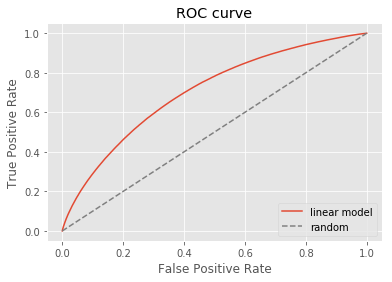

In [311]:
fpr, tpr, _ = metrics.roc_curve(label_test, predpr[:,1])
plt.plot(fpr, tpr, label = 'linear model')
plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right");

In [312]:
metrics.roc_auc_score(label_test, predpr[:,1])

0.70302316288340494

In [268]:
test_df = pd.read_csv("test_dataset.csv")

In [269]:
test_df["TailNum"] = test_df["TailNum"].fillna("UNKNOWN")

test_df['TaxiOut'] = test_df['TaxiOut'].fillna(df['TaxiOut'].mean())

test_df['AirTime'] = test_df['AirTime'].fillna(df['AirTime'].mean())

test_df['DepTime'] = test_df['DepTime'].fillna(df['DepTime'].mean())

test_df['ArrTime'] = test_df['ArrTime'].fillna(df['ArrTime'].mean())

test_df['TaxiIn'] = test_df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [270]:
test_df["Season"] = test_df["Month"].map(lambda m: seasons[m])

In [283]:
reclassMean(test_df, df, "UniqueCarrier", "CarrierChance")
reclassMean(test_df, df, "Dest", "DestChance")
reclassMean(test_df, df, "Origin", "OriginChance")
reclassMean(test_df, df, "TailNum", "Speed")

In [284]:
test_clf_df = test_df.drop(dropped_cols, axis=1)
test_clf_cat = test_clf_df[oh_cols]

In [273]:
dv = feature_extraction.DictVectorizer(sparse=False)
test_clf_oh = dv.fit_transform(test_clf_cat.T.to_dict().values())

In [285]:
test_clf_num = test_clf_df.drop(oh_cols + ["Id"], axis=1)

In [286]:
test_clf = np.concatenate((test_clf_num, test_clf_oh), axis=1)

In [287]:
test_clf.shape

(3504864, 17)

In [288]:
test_pred = opt.predict_proba(test_clf)

In [289]:
test_pred[:, 1]

array([ 0.55668857,  0.53579349,  0.50382141, ...,  0.29191245,
        0.3603659 ,  0.29777507])

In [290]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [291]:
test_pred_df.index.name = "Id"

In [292]:
test_pred_df.head()

,Prediction1
Id,
0,0.556689
1,0.535793
2,0.503821
3,0.416603
4,0.387405


In [293]:
test_pred_df.to_csv("sample_1.csv")